# Session1 - Linear Regression (CORRECTIONS)

In [1]:
import matplotlib
import scipy.io
import numpy as np
import random
from matplotlib import pyplot as plt
try:
    import seaborn as sns
    use_seaborn = True
    sns.set()
except:
    use_seaborn = False

## 1.1 Univariate regression

* **Load the dataset** and plot each feature in function of the blood sugar levels. If you had to select 1 feature only, which one would you keep? 

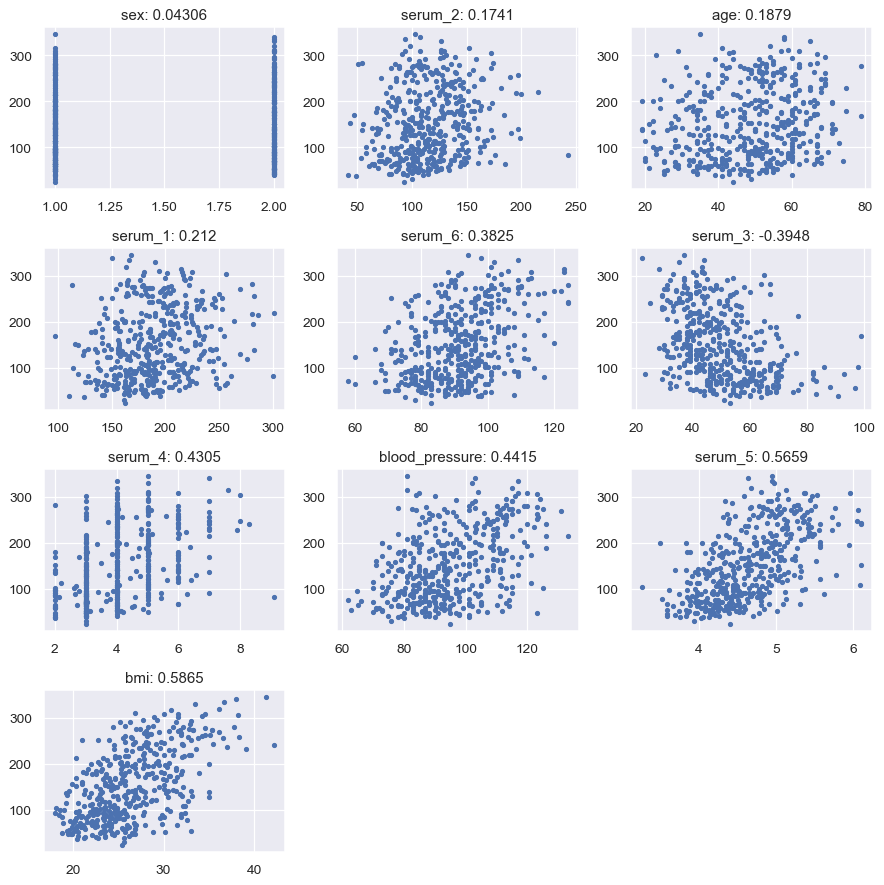

In [8]:
df = scipy.io.loadmat(f"diabetes.mat")
X = df["X"]
n_samples, n_feats = X.shape
t = df["t"]
t_names = ["age", "sex", "bmi", "blood_pressure", "serum_1", 
           "serum_2", "serum_3", "serum_4", "serum_5", "serum_6"]

# Find correlation with vector t
# -> For ease of use, I sorted using correlation instead of doing it vizually
#    This way you can check how good your estimate was :)
corr_vec = np.corrcoef(X,t, rowvar=False)[-1, :n_feats]
most_corr = np.argsort(np.abs(corr_vec))

# Show in decreasing order
fig=plt.figure(figsize=(10, 10), dpi=90)
for i, ind in enumerate(most_corr):
    plt.subplot(n_feats//3+1,3,i+1)
    plt.scatter(X[:,ind], t, s=10)
    plt.title(f"{t_names[ind]}: {corr_vec[ind]:.4}")
plt.tight_layout()
plt.show()

## 1.2 Univariate regression

* **Implement** linear regression using the inverse method. Take a piece of paper to write down vector dimensions before blindly going into the coding part

In [5]:
from sklearn.base import BaseEstimator

class MyLinearRegressor(BaseEstimator):
    def __init__(self, add_bias=True):
        super().__init__()
        self.add_bias = add_bias
        
    def fit(self, X, y):
        if self.add_bias:
            X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=-1)
        if len(y.shape) < 2:
            y = np.expand_dims(y, axis=-1)
        self.coeffs = np.linalg.inv(X.T @ X)@(X.T @ y)
        self.bias = self.coeffs[-1,0] if self.add_bias else 0
        self.coeffs = self.coeffs[:-1,:] if self.add_bias else self.coeffs
        return self
    
    def predict(self, X):
        y = X@self.coeffs + self.bias
        y = np.squeeze(y, axis=-1)
        return y
    
    def fit_predict(self, X, y):
        return self.fit(X, y).predict(X)
    
    def score(self, X, y_true):
        y = self.predict(X)
        return compute_rmse(y, y_true)

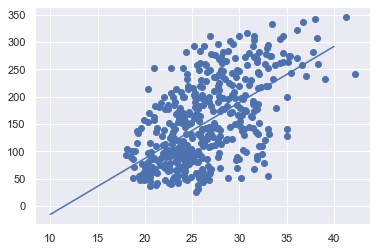

In [6]:
xxx = np.linspace(10,40)
linreg = MyLinearRegressor()
best_indices = most_corr[-1:]
xx = X[:, best_indices]

predict = linreg.fit_predict(xx, t)
plt.scatter(xx, t)
plt.plot(xxx, linreg.predict(xxx[:,None]))

## 1.3 RMSE & Bivariate Linear Reg.
* **Write** the RMSE function
* **Compute** the Linear Regression by selecting 2 features this time. Does the RMSE improve when using 2 vectors

In [8]:
# Compute the Root Mean Square Error
def compute_rmse(predict, target):
        # SOLUTION
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

linreg = MyLinearRegressor()
best_indices = most_corr[-1:]
xx = X[:, best_indices]

predict = linreg.fit_predict(xx, t)

linreg2 = MyLinearRegressor()
best_indices = most_corr[-2:]
xx2 = X[:, best_indices]

predict2 = linreg2.fit_predict(xx2, t)


print(compute_rmse(predict, t))
print(compute_rmse(predict2, t))


62.37352471570989
56.614398140621915


## 1.4 Multivariate Linear Reg.
* **Sort** all the features according to their linearity with the target vector
* **Test** your extended framework by cumulating all the features (first 1, then 2, followed by 3, 4 etc). What do you conclude? Is there an optimal number of features

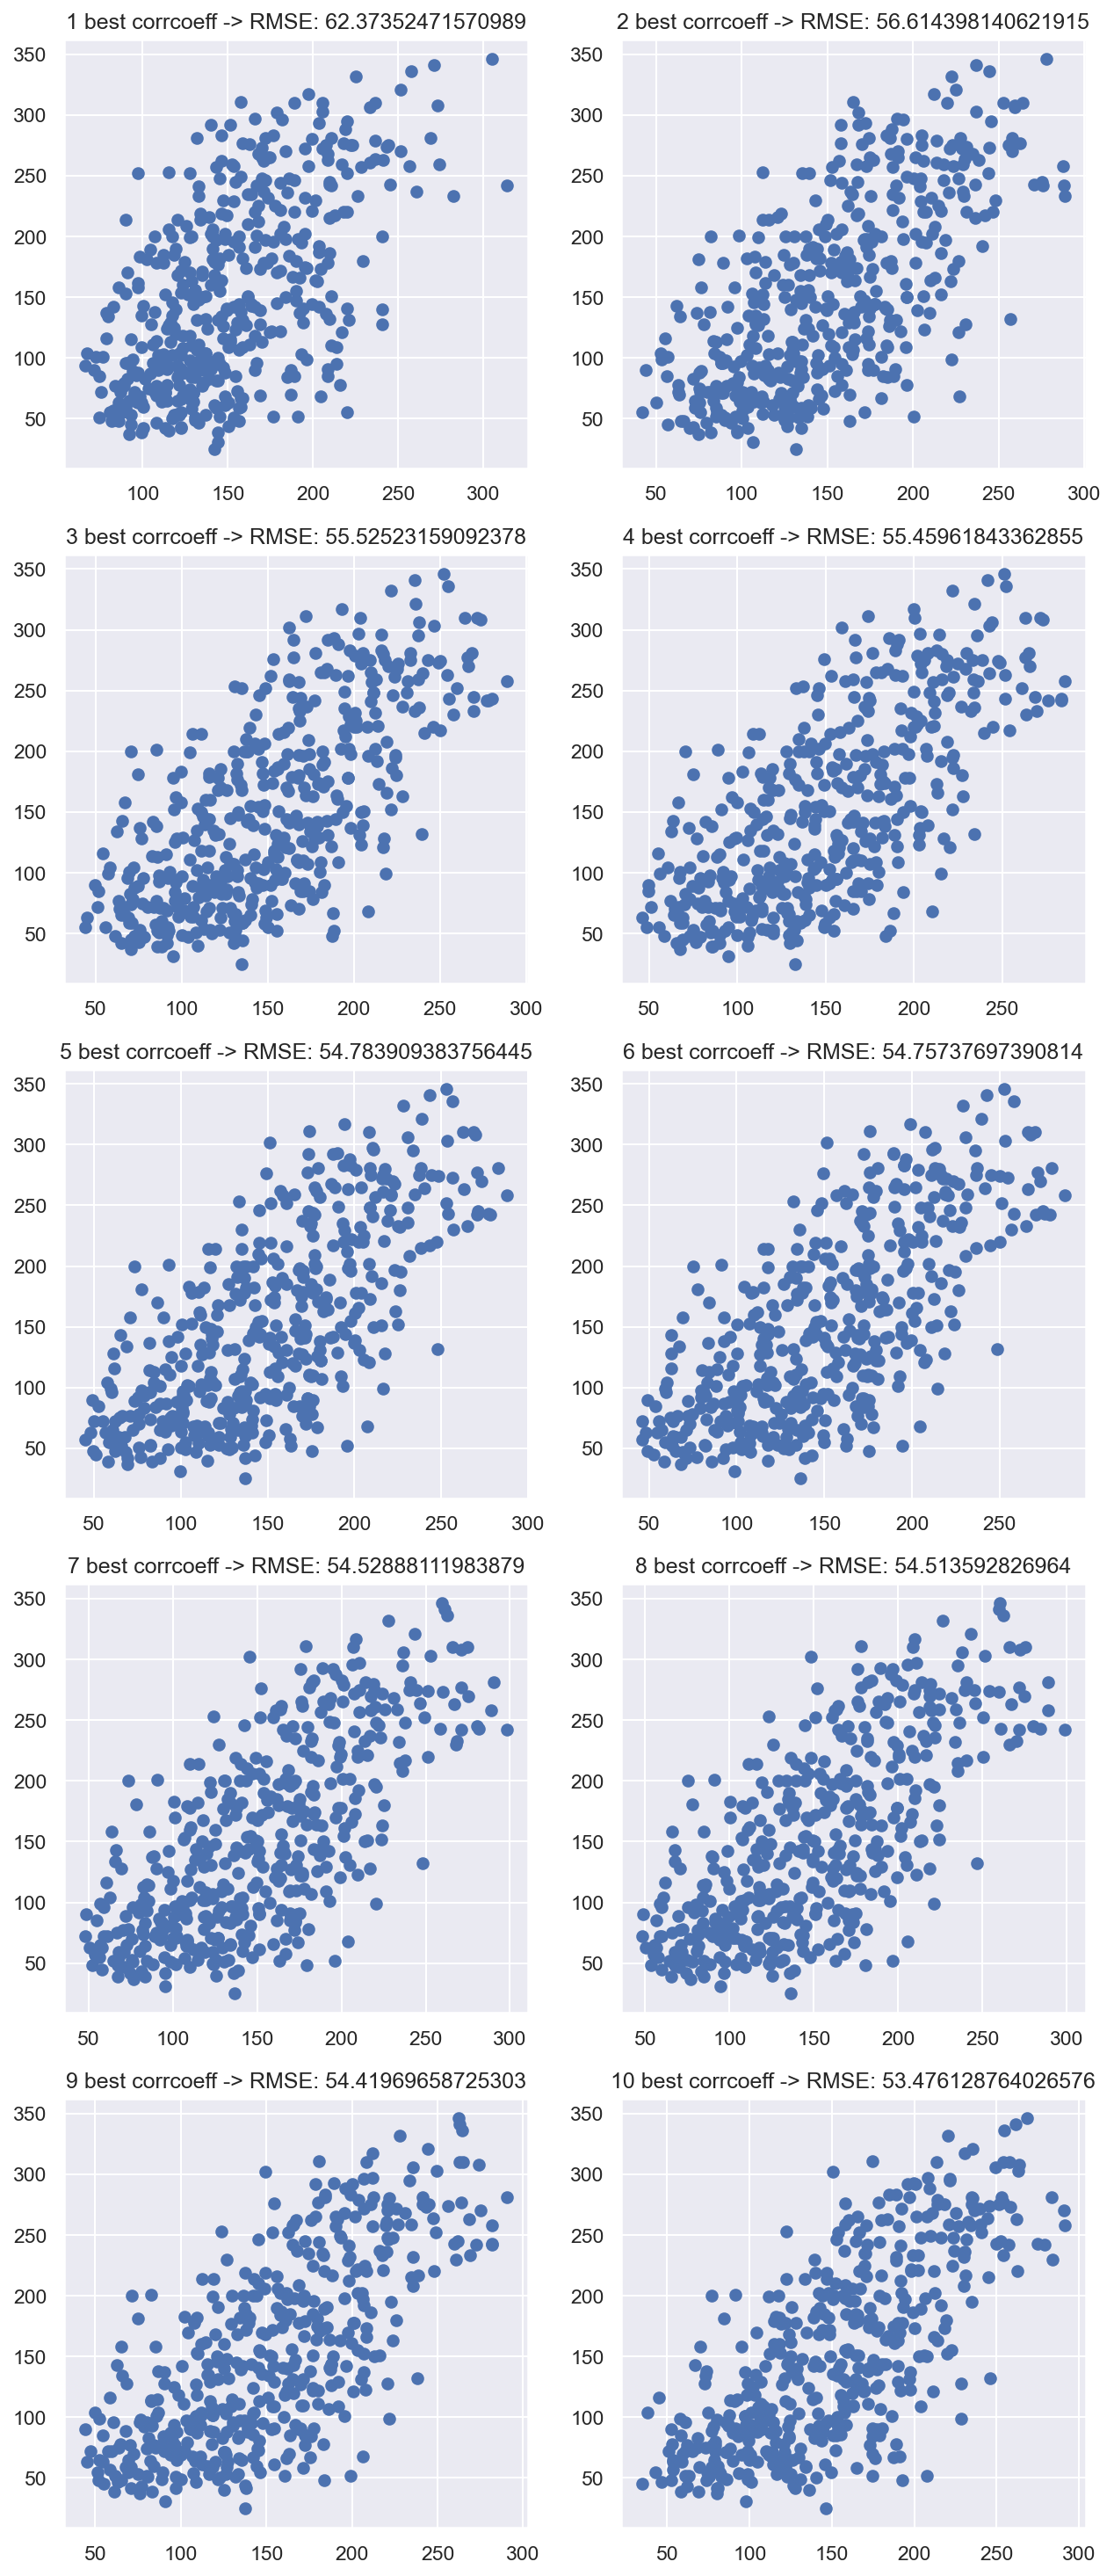

In [9]:
plt.figure(figsize=(10, 25), dpi=150)
# plt.figure(figsize=(5, 12), dpi=75)

for i in range(1,len(t_names)+1):
    # print(i)
    linreg = MyLinearRegressor()
    best_indices = most_corr[-i:]
    xx = X[:, best_indices]

    predict = linreg.fit_predict(xx, t)

    plt.subplot(5,2,i)
    plt.scatter(predict, t)
    plt.title(f'{i} best corrcoeff -> RMSE: {compute_rmse(predict, t)}')

plt.show()

## 1.5 Train-test Generalization
* **Repeat** ex. 1.4 but this time seperating your training set in 2 parts: train and test as given in the code below

Text(0.5, 1.0, '(X2, t2) \n 3 best corrcoeff -> RMSE: 57.53620365982682')

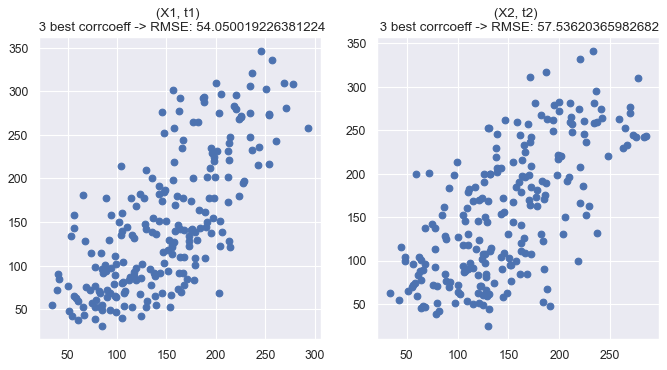

In [10]:
X_copy = X.copy()
t_copy = t.copy()

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_perm, t_perm = unison_shuffled_copies(X_copy, t_copy)
half_index = X_perm.shape[0]//2

X1 = X_perm[:half_index, :]
X2 = X_perm[half_index:, :]

t1 = t_perm[:half_index, :]
t2 = t_perm[half_index:, :]

linreg = MyLinearRegressor()
i = 3
best_indices = most_corr[-i:]

xx1 = X1[:, best_indices]
xx2 = X2[:, best_indices]

linreg.fit(xx1, t1)

plt.figure(figsize=(10, 5), dpi=80)


plt.subplot(1,2,1)
predict_X1 = linreg.predict(xx1)
plt.scatter(predict_X1, t1)
plt.title(f'(X1, t1) \n {i} best corrcoeff -> RMSE: {compute_rmse(predict_X1, t1)}')


plt.subplot(1,2,2)
predict_X2 = linreg.predict(xx2)
plt.scatter(predict_X2, t2)
plt.title(f'(X2, t2) \n {i} best corrcoeff -> RMSE: {compute_rmse(predict_X2, t2)}')


## 1.6 Stochastic Gradient Descent
![image.png](data/image.png)
* On a piece of paper **write** the missing gradient computations
* Once you've computed the equations, **implement** them in the code below and **check** that your solution converges to the same one as the inverse method. Do you think there is more than 1 possible optimal solution? Why?

In [11]:
class MySGDLinearRegressor(MyLinearRegressor):
    def __init__(self, n_epochs=100, lr=1e-3, lr_annealing=0.99, **kwargs):
        super().__init__(**kwargs)
        self.n_epochs = n_epochs
        self.lr = lr
        self.lr_annealing = lr_annealing
        
    def fit(self, X, y):
        assert X.shape[-1] == 2, "Only 2 features are supported for now"
        if len(y.shape) < 2:
            y = np.expand_dims(y, axis=-1)
        
        w0 = 1
        w1 = 1
        b  = -10 if self.add_bias else 0
        lr = self.lr
        ## Compute coeffs
        for epoch in range(self.n_epochs):
            for x, ytrue in zip(X, y):
                # Compute Gradient
                ypred = w0*x[0] + w1*x[1] + b
                dLdypred = 2 * (ypred-ytrue)
                dLdb = dLdbeta = dLdypred
                dLdw0 = dLdbeta*x[0]
                dLdw1 = dLdbeta*x[1]

                # Update weights
                w0 = w0 - lr*dLdw0
                w1 = w1 - lr*dLdw1
                b  = b  - (lr*dLdb if self.add_bias else 0)

                # Update lr 
                lr = lr*self.lr_annealing/(lr+self.lr_annealing)


        self.coeffs = np.array([w0, w1])
        self.bias = (b[0] if self.add_bias else 0)
        return self
best_indices = most_corr[-2:]
xx = X[:, best_indices]
standardized = False
if standardized:
    from sklearn.preprocessing import StandardScaler
    xx = StandardScaler().fit_transform(xx)

add_bias = True
linreg = MyLinearRegressor(add_bias=add_bias)
sgdlinreg = MySGDLinearRegressor(n_epochs=100, lr=1e-3, lr_annealing=0.9, add_bias=add_bias)

real_score = linreg.fit(xx, t).score(xx, t)
sgd_score = sgdlinreg.fit(xx, t).score(xx, t)

print(f"Pseudo-inverse method: {real_score:5.2f} (coeffs: {linreg.coeffs[0][0]:03.2f}, {linreg.coeffs[1][0]:03.2f}, bias={linreg.bias:03.2f})")
print(f"SGD method:            {sgd_score:5.2f} (coeffs: {sgdlinreg.coeffs[0][0]:03.2f}, {sgdlinreg.coeffs[1][0]:03.2f}, bias={sgdlinreg.bias:03.2f})")

Pseudo-inverse method: 56.61 (coeffs: 56.06, 7.28, bias=-299.96)
SGD method:            64.05 (coeffs: 10.11, 5.03, bias=-30.64)


### Additional Comments
Allthought the act of finding the coefficients of a linear regressor presents a convex problem (meaning that there is a verifiable optimal point in the loss landscape), you'll notice that SGD won't be able to easily find this optimal solution.
However, if you remove the bias you'll notice that SGD will converge to a really close solution (you can even get way closer by better tuning of the LR and annealing rate). So this implies that it is really hard to find the optimal value for the bias, why? Simply because the LR is applied uniformly to all the parameters. Since the optimal bias is an order of magnitude farther from its initial value than the weights (>100 compared to ≃10), it can't possible get to that value without an adaptive rescaling of the gradients (methods such as Adam, SGD with momentum have this kind of rescaling). You can try by setting -250 or -270 as the starting point for the bias and you'll notice how much closer you'll get :)

In short, it's important to be able to adapt some values more than others or to choose a correct initial value.
Do you think that using a Stadardscaler (check the sklearn docs!) to rescale the data could help your convergence? Does this transformation change the final RMSE of the linear regrossor that uses the pseudo-invers method? Try to find why (it could come in handy for the exam ;) )